In [1]:
import numpy as np
import pandas as pd

from pulse2percept import electrode2currentmap as e2cm
from pulse2percept import effectivecurrent2brightness as ec2b

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
tsample = 5e-5

# TemporalModel from the Nanduri paper
tm = ec2b.TemporalModel(model='Nanduri', tsample=tsample)

# input amplitude values and expected output
exp_thresh = 30
all_amps = np.array([1.25, 1.5, 2, 4, 6]) * exp_thresh
out_amps = np.array([10, 15, 18, 19, 19])

# input frequency values and expected output
all_freqs = np.array([13, 20, 27, 40, 80, 120])
out_freqs = np.array([7.3, 10, 13, 19, 34, 51])

In [3]:
# Pulse train used in Nanduri et al. (2012)
def get_pulse_train(freq, ampl, pulse_dur=0.45/1000, dur=0.5, tsample=5e-6):
    return e2cm.Psycho2Pulsetrain(freq=freq, dur=dur, 
                                  pulse_dur=pulse_dur, interphase_dur=0,
                                  delay=0.,
                                  tsample=tsample, current_amplitude=ampl, 
                                  pulsetype='cathodicfirst')

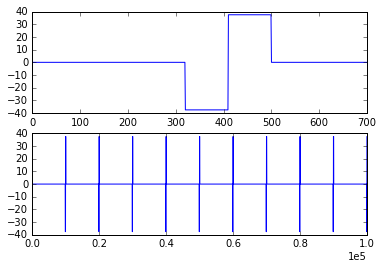

In [4]:
pulse_train = get_pulse_train(20, all_amps[0])
plt.subplot(211)
plt.plot(pulse_train.data[9500:10200])
plt.subplot(212)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.plot(pulse_train.data)

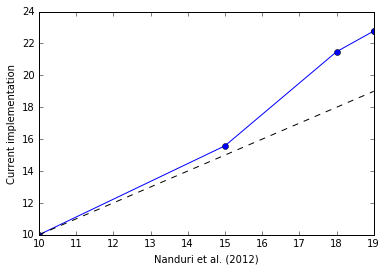

In [5]:
# Run the model on these values and compare model output vs. Nanduri data.
B = []
for ampl in all_amps:
    R4 = tm.model_cascade(get_pulse_train(all_freqs[1], ampl, tsample=tsample), dojit=True)
    B.append(R4.data.max())
B = np.array(B)

# Adjust brightness values by a scaling factor, first element should have B=10
scale_amp = B[0] / out_amps[0]

plt.plot(out_amps, B / scale_amp, 'o-')
plt.plot([out_amps[0], out_amps[-1]], [out_amps[0], out_amps[-1]], '--k')
plt.xlabel('Nanduri et al. (2012)')
plt.ylabel('Current implementation')

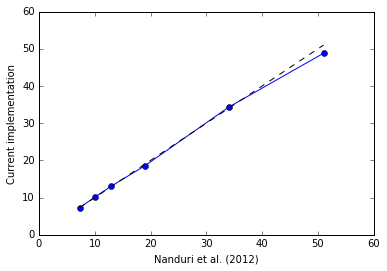

In [6]:
# Run the model on these values and compare model output vs. Nanduri data.
B = []
for freq in all_freqs:
    R4 = tm.model_cascade(get_pulse_train(freq, all_amps[0], tsample=tsample), dojit=True)
    B.append(R4.data.max())
B = np.array(B)

# Adjust brightness values by scaling factor
scale_freq = B[0] / out_freqs[0]

plt.plot(out_freqs, B / scale_freq, 'o-')
plt.plot([out_freqs[0], out_freqs[-1]], [out_freqs[0], out_freqs[-1]], '--k')
plt.xlabel('Nanduri et al. (2012)')
plt.ylabel('Current implementation')

In [7]:
r = e2cm.Retina(axon_map='retina_2000_by_2000.npz', 
                sampling=25, xlo=-1000, xhi=1000, ylo=-1000, yhi=1000)

In [8]:
e_all = e2cm.ElectrodeArray([260], [0], [0], [0])
ecs, cs  = r.electrode_ecs(e_all)

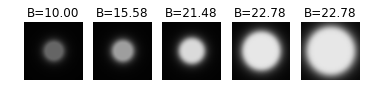

In [21]:
for i in range(len(all_amps)):
    R4 = ec2b.pulse2percept(tm, cs, r, [get_pulse_train(all_freqs[1], all_amps[i], tsample=tsample)], 
                            30, n_jobs=4, dojit=True, tol=0.01)
    plt.subplot(1, len(all_amps), i + 1)
    plt.imshow(R4.data[:, :, 150] / scale_amp, cmap='gray', vmin=0, vmax=25)
    plt.axis('off')
    plt.title("B={:.2f}".format(R4.data.max() / scale_amp))

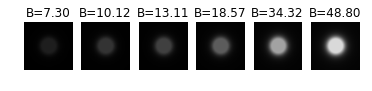

In [22]:
for i in range(len(all_freqs)):
    R4 = ec2b.pulse2percept(tm, cs, r, [get_pulse_train(all_freqs[i], all_amps[0], tsample=tsample)], 
                            30, n_jobs=4, dojit=True, tol=0.01)
    plt.subplot(1, len(all_freqs), i + 1)
    plt.imshow(R4.data[:, :, 150] / scale_freq, cmap='gray', vmin=0, vmax=50)
    plt.axis('off')
    plt.title("B={:.2f}".format(R4.data.max() / scale_freq))